In [86]:
import csv
import ast
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
import contextily as cx
import matplotlib.pyplot as plt

In [3]:
# Open csv file in read mode to understand its structure
with open('data/bike_data.csv', mode='r') as file: 
    csv_reader = csv.reader(file)
    next(csv_reader, None)
    i = 0
    for row in csv_reader:
        if i >= 5:
            break
        print(row)
        i += 1

['0,"{\'trip_id\': \'439f9229-2784-4338-9773-d652c9e568cc\', \'end_time\': 1690844643510, \'coordinates\': [[8.262563, 50.000889], [8.262563, 50.000889], [8.262559, 50.000889], [8.262136, 50.001046], [8.261557, 50.001309], [8.261323, 50.001432], [8.26102, 50.00109], [8.260746, 50.000642], [8.26026, 50.000337], [8.259594, 50.000033], [8.258829, 49.999832], [8.258127, 49.999691], [8.25752, 49.999302], [8.257012, 49.998944], [8.256587, 49.998524], [8.256187, 49.998041], [8.255668, 49.997722], [8.255397, 49.997456], [8.254914, 49.997095], [8.25423, 49.996702], [8.253658, 49.996376], [8.253004, 49.995969], [8.252406, 49.995603], [8.252227, 49.995132], [8.252104, 49.994638], [8.251944, 49.994054], [8.2518, 49.993575], [8.251631, 49.993048], [8.251494, 49.992514], [8.251542, 49.991988], [8.2518, 49.991534], [8.252105, 49.991037], [8.252472, 49.990623], [8.253002, 49.990289], [8.25361, 49.989931], [8.254103, 49.989515], [8.253979, 49.988953], [8.253546, 49.988493], [8.253326, 49.988396], [8.25

In [4]:
# Create dataframe from csv
bike_df = pd.read_csv('data/bike_data.csv', header=None, skiprows=1,  names=['content'])

# Preprocess the data frame into two columns: row ID and trip data
bike_df[['id','trip_data']] = bike_df['content'].str.split(',', n=1, expand=True)
bike_df = bike_df.drop(['content'], axis=1)

In [5]:
bike_df.head()

,id,trip_data
0,0,"""{'trip_id': '439f9229-2784-4338-9773-d652c9e5..."
1,1,"""{'trip_id': 'c55453e0-b755-4158-9d78-d333097e..."
2,2,"""{'trip_id': '916c12fa-965e-4902-a92f-e4804944..."
3,3,"""{'trip_id': '62efe364-30f4-4f48-b80a-d6c193dc..."
4,4,"""{'trip_id': '9140fcef-3652-4b25-80b9-2304c4a3..."


In [6]:
# Extract the trip data from JSON structure into a proper dataframe for further analysis
bike_df['trip_data'] = bike_df['trip_data'].str.strip('"')
bike_df['trip_dict'] = bike_df['trip_data'].apply(ast.literal_eval)
bike_df_upd = pd.json_normalize(bike_df['trip_dict'])

In [7]:
bike_df_upd.head()

,trip_id,end_time,coordinates,vehicle_type,accuracy,trip_distance,propulsion_types,SID,start_time,timestamps_list,trip_duration,vehicle_id,timestamp,_headers.eventType
0,439f9229-2784-4338-9773-d652c9e568cc,1690844643510,"[[8.262563, 50.000889], [8.262563, 50.000889],...",scooter,8.0,1926.0,electric,b2dbe616-456a-4cd6-bd22-9547941dbdd5,1690844227199,"[1690844227000, 1690844229000, 1690844238000, ...",416.0,403328,2023-08-01T00:45:59.936Z,MdsTierEventType
1,c55453e0-b755-4158-9d78-d333097ecb45,1690845074877,"[[8.227722, 49.996441], [8.22736, 49.996296], ...",scooter,8.0,2294.0,electric,b2dbe616-456a-4cd6-bd22-9547941dbdd5,1690844576447,"[1690844576000, 1690844589000, 1690844597000, ...",498.0,420400,2023-08-01T00:45:59.936Z,MdsTierEventType
2,916c12fa-965e-4902-a92f-e4804944093b,1690847157514,"[[8.267058, 49.984197], [8.267061, 49.984202],...",scooter,8.0,3689.0,electric,b2dbe616-456a-4cd6-bd22-9547941dbdd5,1690846148466,"[1690846148000, 1690846160000, 1690846171000, ...",1009.0,419482,2023-08-01T00:45:59.936Z,MdsTierEventType
3,62efe364-30f4-4f48-b80a-d6c193dcdf86,1690845354405,"[[8.259436, 50.005557], [8.259816, 50.0054], [...",scooter,8.0,2613.0,electric,b2dbe616-456a-4cd6-bd22-9547941dbdd5,1690844783757,"[1690844783000, 1690844795000, 1690844806000, ...",571.0,415192,2023-08-01T00:45:59.936Z,MdsTierEventType
4,9140fcef-3652-4b25-80b9-2304c4a3b6da,1690845213966,"[[8.279259, 49.996319], [8.279267, 49.996318],...",scooter,8.0,1538.0,electric,b2dbe616-456a-4cd6-bd22-9547941dbdd5,1690844894374,"[1690844894000, 1690844896000, 1690844906000, ...",320.0,421106,2023-08-01T00:45:59.936Z,MdsTierEventType


##### Trip data:
* trip_id
* start_time – start time in unix (ms)
* end_time – end time in unix (ms)
* timestamps_list – non-equal intervals between timestamps allow to suggest that each time corresponds to a coordinate which allows for further analysis, such as driving style distinction
* coordinates
* vehicle_type – all trips are e-scooter trips
* accuracy – the same accuracy for all trips
* trip_distance
* trip_duration
* propulsion_types – the same type for all trips
* vehicle_id
* timestamp - ???
* _headers.eventType – the same value for all trips

In [9]:
# Convert unix timestamps to a human-readable format
bike_df_upd['end_time'] = pd.to_datetime(bike_df_upd['end_time'], unit='ms')
bike_df_upd['start_time'] = pd.to_datetime(bike_df_upd['start_time'], unit='ms')

In [22]:
# Create a geodataframe with the trips, drop the columns that have the same values for all of the trips
bike_df_upd['geometry'] = bike_df_upd['coordinates'].apply(LineString)
bike_gdf = gpd.GeoDataFrame(bike_df_upd, geometry='geometry', crs='EPSG:4326')
bike_gdf = bike_gdf.drop(['coordinates', '_headers.eventType', 'SID', 'accuracy', 'vehicle_type', 'propulsion_types', 'timestamp'], axis=1)

In [23]:
bike_gdf.head()

,trip_id,end_time,trip_distance,start_time,timestamps_list,trip_duration,vehicle_id,geometry
0,439f9229-2784-4338-9773-d652c9e568cc,2023-07-31 23:04:03.510,1926.0,2023-07-31 22:57:07.199,"[1690844227000, 1690844229000, 1690844238000, ...",416.0,403328,"LINESTRING (8.26256 50.00089, 8.26256 50.00089..."
1,c55453e0-b755-4158-9d78-d333097ecb45,2023-07-31 23:11:14.877,2294.0,2023-07-31 23:02:56.447,"[1690844576000, 1690844589000, 1690844597000, ...",498.0,420400,"LINESTRING (8.22772 49.99644, 8.22736 49.9963,..."
2,916c12fa-965e-4902-a92f-e4804944093b,2023-07-31 23:45:57.514,3689.0,2023-07-31 23:29:08.466,"[1690846148000, 1690846160000, 1690846171000, ...",1009.0,419482,"LINESTRING (8.26706 49.9842, 8.26706 49.9842, ..."
3,62efe364-30f4-4f48-b80a-d6c193dcdf86,2023-07-31 23:15:54.405,2613.0,2023-07-31 23:06:23.757,"[1690844783000, 1690844795000, 1690844806000, ...",571.0,415192,"LINESTRING (8.25944 50.00556, 8.25982 50.0054,..."
4,9140fcef-3652-4b25-80b9-2304c4a3b6da,2023-07-31 23:13:33.966,1538.0,2023-07-31 23:08:14.374,"[1690844894000, 1690844896000, 1690844906000, ...",320.0,421106,"LINESTRING (8.27926 49.99632, 8.27927 49.99632..."


In [83]:
# List all unique dates
bike_gdf['start_time'].dt.date.unique()

array([datetime.date(2023, 7, 31), datetime.date(2023, 8, 1),
       datetime.date(2023, 8, 2), datetime.date(2023, 8, 3),
       datetime.date(2023, 8, 4), datetime.date(2023, 8, 5),
       datetime.date(2023, 8, 6), datetime.date(2023, 8, 7),
       datetime.date(2023, 8, 8), datetime.date(2023, 8, 9),
       datetime.date(2023, 8, 10), datetime.date(2023, 8, 11),
       datetime.date(2023, 8, 12), datetime.date(2023, 8, 13),
       datetime.date(2023, 8, 14), datetime.date(2023, 8, 15),
       datetime.date(2023, 8, 16), datetime.date(2023, 8, 17),
       datetime.date(2023, 8, 18), datetime.date(2023, 8, 19),
       datetime.date(2023, 8, 20), datetime.date(2023, 8, 21),
       datetime.date(2023, 8, 22), datetime.date(2023, 8, 23),
       datetime.date(2023, 8, 24), datetime.date(2023, 8, 25),
       datetime.date(2023, 8, 26), datetime.date(2023, 8, 27),
       datetime.date(2023, 8, 28), datetime.date(2023, 8, 29),
       datetime.date(2023, 8, 30), datetime.date(2023, 8, 31),
 

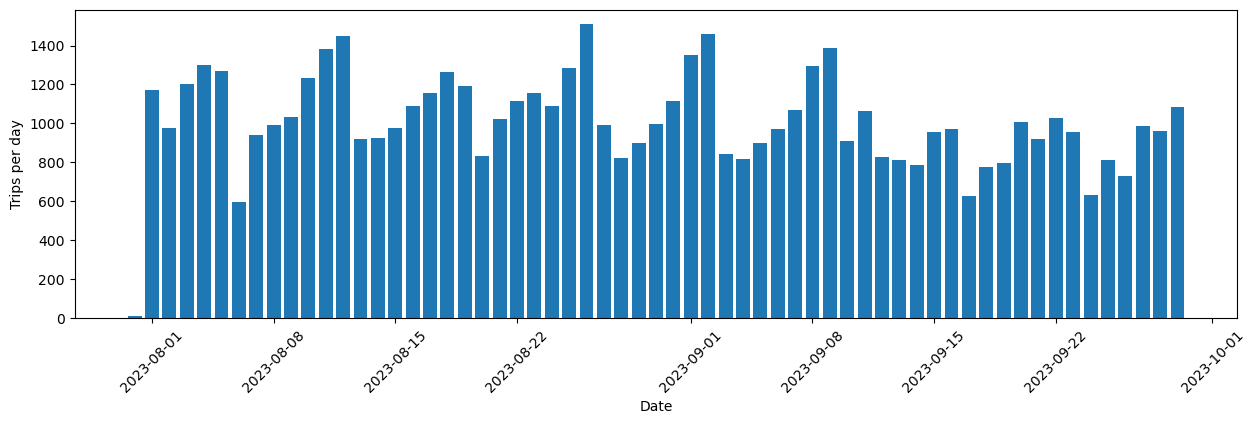

In [84]:
# Plot all unique dates and the number of trips per day
unique_dates_df = bike_gdf['start_time'].dt.date.value_counts().rename_axis('date').rename('trips_per_day').to_frame().reset_index()
unique_dates_df['date'] = pd.to_datetime(unique_dates_df['date'])

fig, ax = plt.subplots(figsize=(15, 4))
ax.bar(unique_dates_df.date, unique_dates_df.trips_per_day)
ax.set_xlabel('Date')
ax.set_ylabel('Trips per day')
ax.tick_params('x', rotation=45)
plt.show()

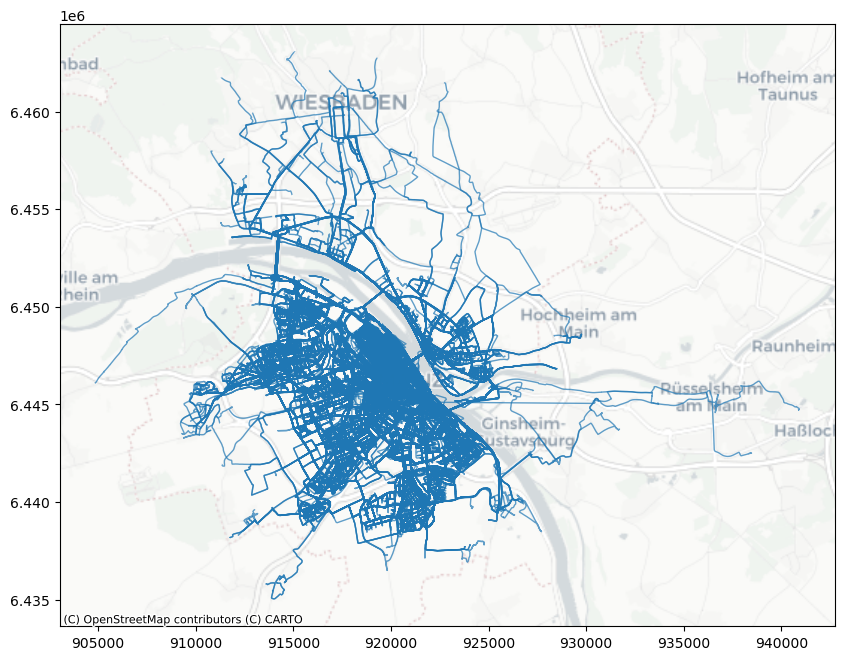

In [85]:
# Plot trips on the map to get an initial idea of the location
ax = bike_gdf.to_crs(epsg=3857).plot(figsize=(10,10), alpha=0.7, linewidth=1)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

A first look at the data shows that escooter trips happened in Mainz and the surrounding area between July 7 and September 29, 2023. Further analysis of the trips can be found in the notebook 1_analysis.ipynb

In [87]:
# Save preprocessed file
bike_gdf.to_parquet('data/l_escooter_trips.parquet')